# fAnoGAN_agu전

- parameter   
  : learning_rate = 4e-1   
  : learning_G_per_D=15

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100  # z벡터의 잠재공간(latent space)의 크기
workers = 4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 4e-1

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
data_root = "/home/piai/Desktop/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 1012
device : cuda:0


# MODEL

In [4]:
# fast AnoGAN : Generative Adversarial Networks Model with AutoEncoder

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1, 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature


# === Encoder Model ===
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def E_block(in_features, out_features, BN=True):
            if BN:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                         nn.BatchNorm2d(out_features),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 3, bias=False),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        # ============== Feature 추출 ==============
        self.E_extract_feature = nn.Sequential(
            # -------input is 1 x 64 x 64-------
            *E_block(channel, img_size, BN=False),
            # -------state is 64 x 32 x 32-------
            *E_block(img_size, img_size*2, BN=True),
            # -------state is 128 x 16 x 16-------
            *E_block(img_size*2, img_size*4, BN=True),
            # -------state is 256 x 8 x 8-------
            *E_block(img_size*4, img_size*8, BN=True),
        )
        
        # =============== Encoder Training layer ===============
        self.E_validate = nn.Sequential(
            # -------state is 512 x 4 x 4-------
            nn.Conv2d(img_size*8, latent_size, 4, 1, 0, bias=False),
            nn.Tanh()
            # -------state is 100 x 97 x 97-------
        )
        
    def forward(self, input):
        feature = self.E_extract_feature(input)
        validity = self.E_validate(feature)
        
        return validity

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G,E 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)
E = Encoder().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)
E.apply(weights_init)

# Binary cross entropy loss and optimizer
DCGAN_criterion = nn.BCELoss()
AE_criterion = nn.MSELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))
E_optimizer = torch.optim.Adam(E.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)
#print(E)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train_DCGAN(epoch, learning_G_per_D = 8):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train D
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = DCGAN_criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = DCGAN_criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train G
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification,_ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = DCGAN_criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x):%.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [7]:
for epoch in range(epochs):
    train_DCGAN(epoch, learning_G_per_D = 15)

/home/piai/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/15]
- D_loss : 1.3821 / G_loss : 0.0000
- D(x):0.5034 / D(G(z1)) : 0.5012 / D(G(z2)) : 1.0000
[1/100][1/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][2/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][3/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][4/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][5/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][6/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[1/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0

[6/100][3/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][4/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][5/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][6/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[6/100][12/15]
- D_loss : 100.0000 / G_loss 

[11/100][5/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[11/100][6/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[11/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[11/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[11/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[11/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[11/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[11/100][12/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[11/100][13/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[11/100][14/15]
- D_loss : 100.00

[16/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[16/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[16/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[16/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[16/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[16/100][12/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[16/100][13/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[16/100][14/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][0/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[17/100][1/15]
- D_loss : 100.00

[21/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[21/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[21/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[21/100][12/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[21/100][13/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[21/100][14/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[22/100][0/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[22/100][1/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[22/100][2/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[22/100][3/15]
- D_loss : 100.00

[26/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[26/100][12/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[26/100][13/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[26/100][14/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[27/100][0/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[27/100][1/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[27/100][2/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[27/100][3/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[27/100][4/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[27/100][5/15]
- D_loss : 100.000

[31/100][13/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[31/100][14/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[32/100][0/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[32/100][1/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[32/100][2/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[32/100][3/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[32/100][4/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[32/100][5/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[32/100][6/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[32/100][7/15]
- D_loss : 100.0000 

[37/100][0/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[37/100][1/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[37/100][2/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[37/100][3/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[37/100][4/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[37/100][5/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[37/100][6/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[37/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[37/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[37/100][9/15]
- D_loss : 100.0000 / 

[42/100][2/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[42/100][3/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[42/100][4/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[42/100][5/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[42/100][6/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[42/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[42/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[42/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[42/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[42/100][11/15]
- D_loss : 100.0000 

[47/100][4/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[47/100][5/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[47/100][6/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[47/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[47/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[47/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[47/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[47/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[47/100][12/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[47/100][13/15]
- D_loss : 100.000

[52/100][6/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[52/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[52/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[52/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[52/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[52/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[52/100][12/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[52/100][13/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[52/100][14/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[53/100][0/15]
- D_loss : 100.00

[57/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[57/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[57/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[57/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[57/100][12/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[57/100][13/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[57/100][14/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[58/100][0/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[58/100][1/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[58/100][2/15]
- D_loss : 100.00

[62/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[62/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[62/100][12/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[62/100][13/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[62/100][14/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[63/100][0/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[63/100][1/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[63/100][2/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[63/100][3/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[63/100][4/15]
- D_loss : 100.00

[67/100][12/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[67/100][13/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[67/100][14/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[68/100][0/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[68/100][1/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[68/100][2/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[68/100][3/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[68/100][4/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[68/100][5/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[68/100][6/15]
- D_loss : 100.0000

[72/100][14/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][0/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][1/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][2/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][3/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][4/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][5/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][6/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[73/100][8/15]
- D_loss : 100.0000 /

[78/100][1/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][2/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][3/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][4/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][5/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][6/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[78/100][10/15]
- D_loss : 100.0000 /

[83/100][3/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][4/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][5/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][6/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[83/100][12/15]
- D_loss : 100.0000

[88/100][5/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[88/100][6/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[88/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[88/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[88/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[88/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[88/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[88/100][12/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[88/100][13/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[88/100][14/15]
- D_loss : 100.00

[93/100][7/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[93/100][8/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[93/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[93/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[93/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[93/100][12/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[93/100][13/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[93/100][14/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[94/100][0/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[94/100][1/15]
- D_loss : 100.00

[98/100][9/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[98/100][10/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[98/100][11/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[98/100][12/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[98/100][13/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[98/100][14/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[99/100][0/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[99/100][1/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[99/100][2/15]
- D_loss : 100.0000 / G_loss : 0.0000
- D(x):1.0000 / D(G(z1)) : 1.0000 / D(G(z2)) : 1.0000
[99/100][3/15]
- D_loss : 100.00

# Animation

In [8]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

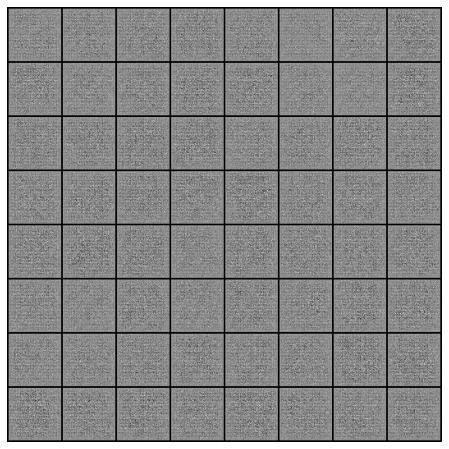

In [9]:
animate_gen_imgs()

# Trian : izif E

In [10]:
G.eval()
D.eval()

kappa = 1.0
E_losses = []

iters = 0
AE_img_list = []

def train_AE(epoch):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        real_imgs = data[0].to(device)
        
        E_optimizer.zero_grad()
        
        #print(real_imgs.shape)
        E_validity = E(real_imgs)
        
        fake_imgs = G(E_validity)
        
        _, real_features = D.forward(real_imgs)
        _, fake_features = D.forward(fake_imgs)
        
        
        # izif architecture
        imgs_loss = AE_criterion(real_imgs, fake_imgs)
        features_loss = AE_criterion(real_features, fake_features)
        E_loss = imgs_loss + kappa*features_loss
        
        E_loss.backward()
        E_optimizer.step()
        
        # =============================================================
        # print
        # =============================================================
        print('[%d/%d][%d/%d]\n- E_loss: %.4f\n'
              %(epoch+1, epochs, i, len(data_loader), E_loss.item()))
        
        # Save Losses for plotting later
        E_losses.append(E_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(E_validity).detach().cpu()
            AE_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [11]:
for epoch in range(epochs):
    train_AE(epoch)

[1/100][0/15]
- E_loss: 717.4592

[1/100][1/15]
- E_loss: 557.8713

[1/100][2/15]
- E_loss: 880.5656

[1/100][3/15]
- E_loss: 647.7964

[1/100][4/15]
- E_loss: 703.7905

[1/100][5/15]
- E_loss: 596.7944

[1/100][6/15]
- E_loss: 748.0756

[1/100][7/15]
- E_loss: 564.4368

[1/100][8/15]
- E_loss: 651.6320

[1/100][9/15]
- E_loss: 898.6578

[1/100][10/15]
- E_loss: 676.0639

[1/100][11/15]
- E_loss: 536.2300

[1/100][12/15]
- E_loss: 642.6964

[1/100][13/15]
- E_loss: 723.0755

[1/100][14/15]
- E_loss: 845.2412

[2/100][0/15]
- E_loss: 600.5962

[2/100][1/15]
- E_loss: 598.8723

[2/100][2/15]
- E_loss: 452.8632

[2/100][3/15]
- E_loss: 608.7448

[2/100][4/15]
- E_loss: 835.8152

[2/100][5/15]
- E_loss: 780.2802

[2/100][6/15]
- E_loss: 628.9844

[2/100][7/15]
- E_loss: 680.2468

[2/100][8/15]
- E_loss: 610.2555

[2/100][9/15]
- E_loss: 644.3682

[2/100][10/15]
- E_loss: 976.0184

[2/100][11/15]
- E_loss: 805.3661

[2/100][12/15]
- E_loss: 670.6167

[2/100][13/15]
- E_loss: 610.3128

[2/10

[16/100][12/15]
- E_loss: 638.1172

[16/100][13/15]
- E_loss: 605.3016

[16/100][14/15]
- E_loss: 646.0873

[17/100][0/15]
- E_loss: 519.0298

[17/100][1/15]
- E_loss: 892.9231

[17/100][2/15]
- E_loss: 600.4727

[17/100][3/15]
- E_loss: 783.1109

[17/100][4/15]
- E_loss: 683.8151

[17/100][5/15]
- E_loss: 661.7545

[17/100][6/15]
- E_loss: 758.6949

[17/100][7/15]
- E_loss: 656.2724

[17/100][8/15]
- E_loss: 676.1773

[17/100][9/15]
- E_loss: 625.9426

[17/100][10/15]
- E_loss: 545.3835

[17/100][11/15]
- E_loss: 734.2136

[17/100][12/15]
- E_loss: 841.6117

[17/100][13/15]
- E_loss: 558.9998

[17/100][14/15]
- E_loss: 799.0436

[18/100][0/15]
- E_loss: 675.8485

[18/100][1/15]
- E_loss: 713.7386

[18/100][2/15]
- E_loss: 910.0394

[18/100][3/15]
- E_loss: 668.6165

[18/100][4/15]
- E_loss: 652.0480

[18/100][5/15]
- E_loss: 694.3835

[18/100][6/15]
- E_loss: 685.1955

[18/100][7/15]
- E_loss: 705.4385

[18/100][8/15]
- E_loss: 676.1265

[18/100][9/15]
- E_loss: 779.9974

[18/100][10/

[32/100][4/15]
- E_loss: 742.9262

[32/100][5/15]
- E_loss: 798.6226

[32/100][6/15]
- E_loss: 632.2072

[32/100][7/15]
- E_loss: 693.5870

[32/100][8/15]
- E_loss: 649.8427

[32/100][9/15]
- E_loss: 729.8327

[32/100][10/15]
- E_loss: 602.4050

[32/100][11/15]
- E_loss: 618.2190

[32/100][12/15]
- E_loss: 669.8372

[32/100][13/15]
- E_loss: 703.9518

[32/100][14/15]
- E_loss: 828.6545

[33/100][0/15]
- E_loss: 726.3972

[33/100][1/15]
- E_loss: 653.5945

[33/100][2/15]
- E_loss: 593.4877

[33/100][3/15]
- E_loss: 670.7366

[33/100][4/15]
- E_loss: 640.5126

[33/100][5/15]
- E_loss: 771.2324

[33/100][6/15]
- E_loss: 680.7996

[33/100][7/15]
- E_loss: 672.7155

[33/100][8/15]
- E_loss: 805.0914

[33/100][9/15]
- E_loss: 630.4766

[33/100][10/15]
- E_loss: 606.5076

[33/100][11/15]
- E_loss: 760.5942

[33/100][12/15]
- E_loss: 691.6003

[33/100][13/15]
- E_loss: 728.4315

[33/100][14/15]
- E_loss: 700.8021

[34/100][0/15]
- E_loss: 642.2109

[34/100][1/15]
- E_loss: 837.7505

[34/100][2

[47/100][12/15]
- E_loss: 860.0021

[47/100][13/15]
- E_loss: 547.3535

[47/100][14/15]
- E_loss: 600.5600

[48/100][0/15]
- E_loss: 568.5207

[48/100][1/15]
- E_loss: 671.2962

[48/100][2/15]
- E_loss: 699.4989

[48/100][3/15]
- E_loss: 902.3737

[48/100][4/15]
- E_loss: 591.1314

[48/100][5/15]
- E_loss: 726.3232

[48/100][6/15]
- E_loss: 742.2531

[48/100][7/15]
- E_loss: 580.0131

[48/100][8/15]
- E_loss: 687.3788

[48/100][9/15]
- E_loss: 767.3834

[48/100][10/15]
- E_loss: 621.6534

[48/100][11/15]
- E_loss: 771.3541

[48/100][12/15]
- E_loss: 644.8412

[48/100][13/15]
- E_loss: 757.1516

[48/100][14/15]
- E_loss: 757.4949

[49/100][0/15]
- E_loss: 518.1852

[49/100][1/15]
- E_loss: 727.5322

[49/100][2/15]
- E_loss: 698.4414

[49/100][3/15]
- E_loss: 715.2164

[49/100][4/15]
- E_loss: 667.9287

[49/100][5/15]
- E_loss: 742.3038

[49/100][6/15]
- E_loss: 566.8175

[49/100][7/15]
- E_loss: 739.7918

[49/100][8/15]
- E_loss: 690.8782

[49/100][9/15]
- E_loss: 838.0862

[49/100][10/

[63/100][4/15]
- E_loss: 772.8147

[63/100][5/15]
- E_loss: 635.7460

[63/100][6/15]
- E_loss: 579.2613

[63/100][7/15]
- E_loss: 714.3624

[63/100][8/15]
- E_loss: 788.2769

[63/100][9/15]
- E_loss: 862.8262

[63/100][10/15]
- E_loss: 709.4832

[63/100][11/15]
- E_loss: 588.7493

[63/100][12/15]
- E_loss: 758.9647

[63/100][13/15]
- E_loss: 375.9120

[63/100][14/15]
- E_loss: 696.3959

[64/100][0/15]
- E_loss: 589.3189

[64/100][1/15]
- E_loss: 815.6542

[64/100][2/15]
- E_loss: 700.4315

[64/100][3/15]
- E_loss: 745.0067

[64/100][4/15]
- E_loss: 553.4072

[64/100][5/15]
- E_loss: 518.4925

[64/100][6/15]
- E_loss: 673.9482

[64/100][7/15]
- E_loss: 769.8660

[64/100][8/15]
- E_loss: 715.8152

[64/100][9/15]
- E_loss: 764.2941

[64/100][10/15]
- E_loss: 753.2540

[64/100][11/15]
- E_loss: 608.1312

[64/100][12/15]
- E_loss: 641.3201

[64/100][13/15]
- E_loss: 774.5002

[64/100][14/15]
- E_loss: 691.8345

[65/100][0/15]
- E_loss: 782.2755

[65/100][1/15]
- E_loss: 555.1045

[65/100][2

[78/100][12/15]
- E_loss: 628.9301

[78/100][13/15]
- E_loss: 816.1032

[78/100][14/15]
- E_loss: 619.3000

[79/100][0/15]
- E_loss: 945.2708

[79/100][1/15]
- E_loss: 808.7314

[79/100][2/15]
- E_loss: 734.1650

[79/100][3/15]
- E_loss: 597.8857

[79/100][4/15]
- E_loss: 651.9142

[79/100][5/15]
- E_loss: 613.7894

[79/100][6/15]
- E_loss: 614.6461

[79/100][7/15]
- E_loss: 704.1754

[79/100][8/15]
- E_loss: 643.7579

[79/100][9/15]
- E_loss: 586.4560

[79/100][10/15]
- E_loss: 671.8369

[79/100][11/15]
- E_loss: 710.1003

[79/100][12/15]
- E_loss: 657.4785

[79/100][13/15]
- E_loss: 696.7825

[79/100][14/15]
- E_loss: 741.3036

[80/100][0/15]
- E_loss: 805.2256

[80/100][1/15]
- E_loss: 628.9485

[80/100][2/15]
- E_loss: 776.0045

[80/100][3/15]
- E_loss: 616.8807

[80/100][4/15]
- E_loss: 651.2837

[80/100][5/15]
- E_loss: 793.1726

[80/100][6/15]
- E_loss: 669.9155

[80/100][7/15]
- E_loss: 600.9959

[80/100][8/15]
- E_loss: 699.6846

[80/100][9/15]
- E_loss: 753.1306

[80/100][10/

[94/100][4/15]
- E_loss: 831.4914

[94/100][5/15]
- E_loss: 533.6175

[94/100][6/15]
- E_loss: 629.5118

[94/100][7/15]
- E_loss: 608.3181

[94/100][8/15]
- E_loss: 689.0436

[94/100][9/15]
- E_loss: 592.1053

[94/100][10/15]
- E_loss: 539.5336

[94/100][11/15]
- E_loss: 862.6877

[94/100][12/15]
- E_loss: 605.8933

[94/100][13/15]
- E_loss: 815.4896

[94/100][14/15]
- E_loss: 732.6254

[95/100][0/15]
- E_loss: 987.6246

[95/100][1/15]
- E_loss: 717.8807

[95/100][2/15]
- E_loss: 744.4769

[95/100][3/15]
- E_loss: 755.2505

[95/100][4/15]
- E_loss: 543.5699

[95/100][5/15]
- E_loss: 688.4721

[95/100][6/15]
- E_loss: 589.8786

[95/100][7/15]
- E_loss: 699.0498

[95/100][8/15]
- E_loss: 638.8654

[95/100][9/15]
- E_loss: 567.3956

[95/100][10/15]
- E_loss: 706.0656

[95/100][11/15]
- E_loss: 674.2700

[95/100][12/15]
- E_loss: 767.8380

[95/100][13/15]
- E_loss: 455.9185

[95/100][14/15]
- E_loss: 762.9668

[96/100][0/15]
- E_loss: 750.6995

[96/100][1/15]
- E_loss: 587.6320

[96/100][2

# Loss Graph

In [12]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.plot(E_losses, label="E")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

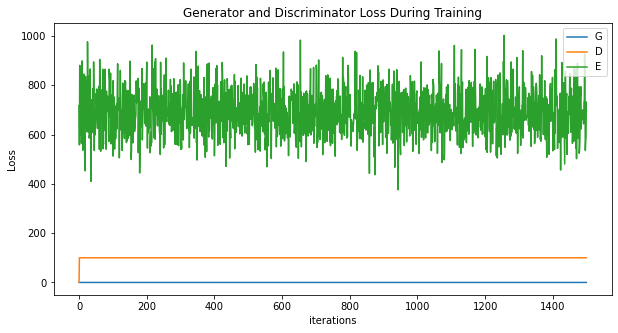

In [13]:
plot_train_loss()

---

# Test Data

In [14]:
test_data_root = "/home/piai/POSCO-GANgineer/OhSeHyeon/source/dataset/test/test_DualPhaseSteel"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# img 비교 함수

In [16]:
def compare_imgs(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    
    # anomaly_imgs
    anomaly_imgs.append(anomaly_img)

    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

# Test

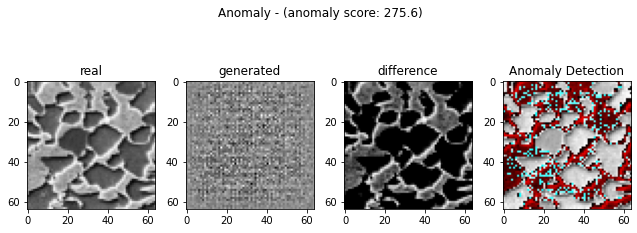

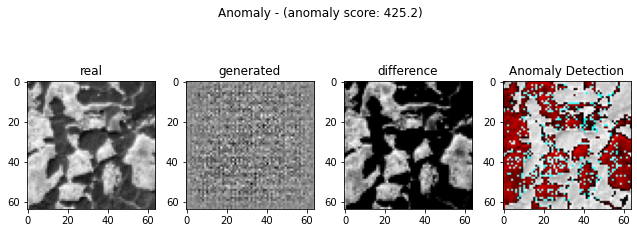

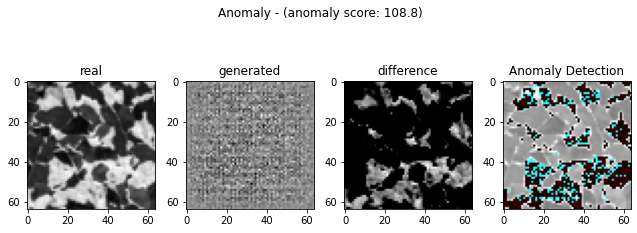

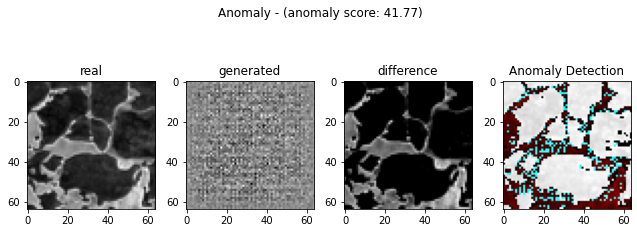

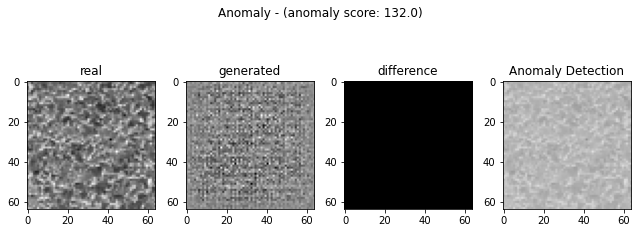

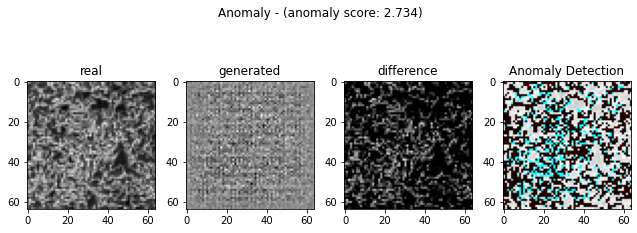

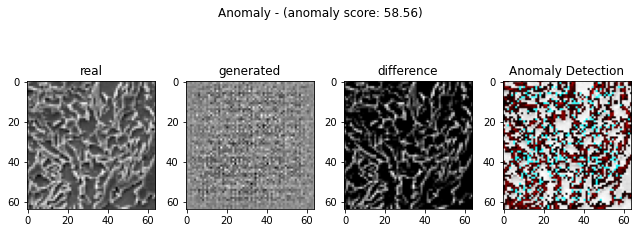

In [17]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

ano_criterion = nn.MSELoss()
G.eval()
D.eval()
E.eval()

# with open("score.csv", "w") as f:
#         f.write("label,img_distance,anomaly_score,z_distance\n")

for i, data in enumerate(test_data_loader, 0):
    real_img = data[0].to(device)

    real_z = E(real_img) # 진짜 이미지의 latent vector
    fake_img = G(real_z) # G에 넣어서 가짜 이미지 생성.
    fake_z = E(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    _, real_feature = D.forward(real_img) # 1, 256
    _, fake_feature = D.forward(fake_img)

    img_distance = ano_criterion(fake_img, real_img)
    loss_feature = ano_criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = ano_criterion(fake_z, real_z)
    
#     with open("score.csv", "a") as f:
#             f.write(f"{label.item()},{img_distance},"
#                     f"{anomaly_score},{z_distance}\n")
            
#     print(f"{label.item()}, {img_distance}, "
#           f"{anomaly_score}, {z_distance}\n")
    compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.50927734 0.55151367 0.31054688 0.38256836 0.         0.52539062
 0.5456543 ]


---

# 분산 추출

In [19]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [20]:
cal_corr_coeffis()

print(corr_coeffis)

[0.03473810627867062, 0.09146969461696353, -0.137916380989793, 0.06333316857680857, -inf, -0.022998824172218352, -0.04035203194468062]


---

# 모델 저장 및 읽기

In [21]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "G" : G.state_dict(),
        "E" : E.state_dict()
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [22]:
save_pretrained()

In [23]:
pretrained_D = Discriminator().to(device)
pretrained_G = Generator().to(device)
pretrained_E = Encoder().to(device)

def load_pretrained():
    global pretrained_D
    global pretrained_G
    global pretrained_E
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_G.load_state_dict(pretrained["G"])
    pretrained_E.load_state_dict(pretrained["E"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_G)
    #print("pretrained_E :", pretrained_E)

In [24]:
load_pretrained()

In [25]:
def test():
    ano_criterion = nn.MSELoss()
    pretrained_G.eval()
    pretrained_D.eval()
    pretrained_E.eval()

    # with open("score.csv", "w") as f:
    #         f.write("label,img_distance,anomaly_score,z_distance\n")

    for i, data in enumerate(test_data_loader, 0):
        real_img = data[0].to(device)

        real_z = pretrained_E(real_img) # 진짜 이미지의 latent vector
        fake_img = pretrained_G(real_z) # G에 넣어서 가짜 이미지 생성.
        fake_z = pretrained_E(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

        _, real_feature = pretrained_D.forward(real_img) # 1, 256
        _, fake_feature = pretrained_D.forward(fake_img)

        img_distance = ano_criterion(fake_img, real_img)
        loss_feature = ano_criterion(fake_feature, real_feature)

        anomaly_score = img_distance + kappa*loss_feature

        z_distance = ano_criterion(fake_z, real_z)

    #     with open("score.csv", "a") as f:
    #             f.write(f"{label.item()},{img_distance},"
    #                     f"{anomaly_score},{z_distance}\n")

    #     print(f"{label.item()}, {img_distance}, "
    #           f"{anomaly_score}, {z_distance}\n")
        compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

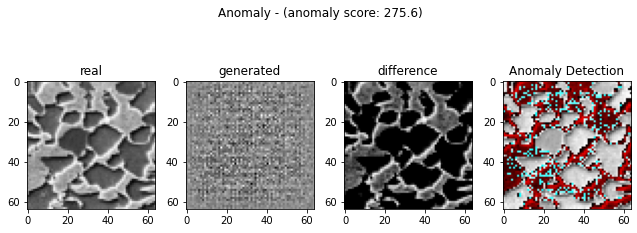

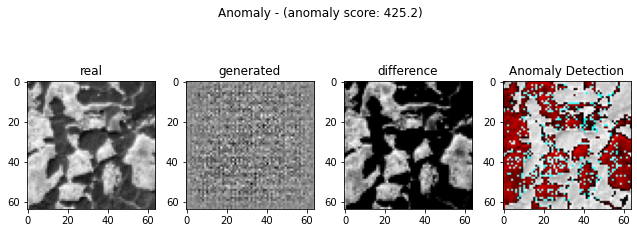

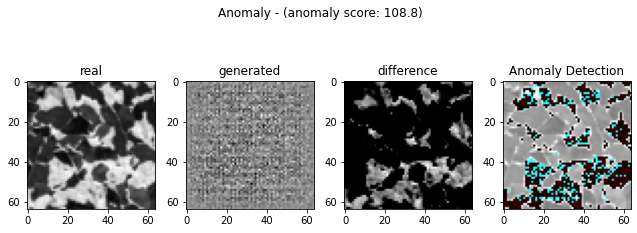

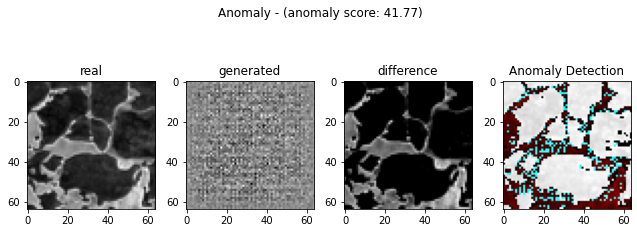

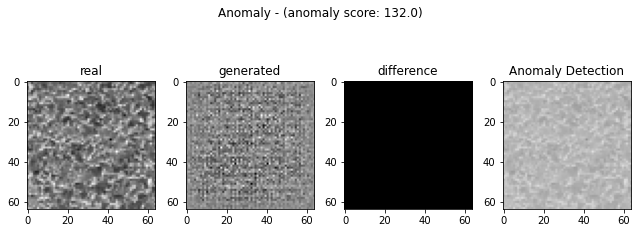

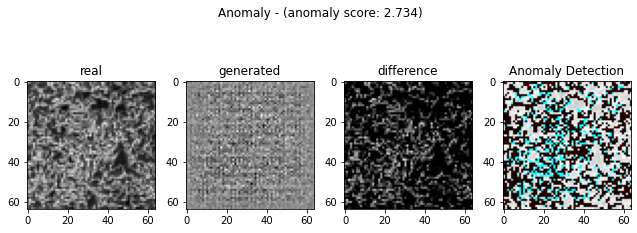

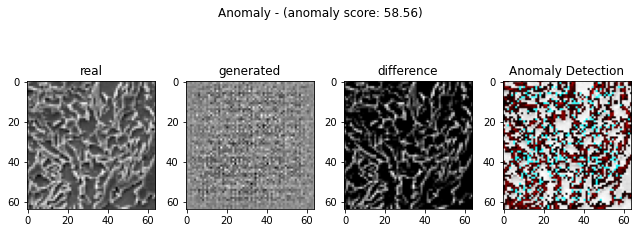

In [26]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [27]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.50927734 0.55151367 0.31054688 0.38256836 0.         0.52539062
 0.5456543 ]


In [28]:
cal_corr_coeffis()

print(corr_coeffis)

[0.03473810627867062, 0.09146969461696353, -0.137916380989793, 0.06333316857680857, -inf, -0.022998824172218352, -0.04035203194468062]


---

# anomaly detection 이미지 추출

In [29]:
anomaly_imgs

[array([[[242, 242, 242],
         [246, 246, 246],
         [121,   0,   0],
         ...,
         [210, 210, 210],
         [176, 176, 176],
         [222, 222, 222]],
 
        [[248, 248, 248],
         [242, 242, 242],
         [ 87,   0,   0],
         ...,
         [238, 238, 238],
         [238, 238, 238],
         [190, 190, 190]],
 
        [[236, 236, 236],
         [230, 230, 230],
         [ 77,   0,   0],
         ...,
         [230, 230, 230],
         [232, 232, 232],
         [238, 238, 238]],
 
        ...,
 
        [[230, 230, 230],
         [248, 248, 248],
         [212, 212, 212],
         ...,
         [142, 142, 142],
         [ 85,  85,  85],
         [130, 130, 130]],
 
        [[228, 228, 228],
         [244, 244, 244],
         [230, 230, 230],
         ...,
         [105, 105, 105],
         [150, 150, 150],
         [252, 252, 252]],
 
        [[218, 218, 218],
         [228, 228, 228],
         [246, 246, 246],
         ...,
         [182, 182, 182],
  

# 이미지 저장 함수

In [30]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs_최종"):
        os.mkdir("anomaly_imgs_최종")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [31]:
save_imgs("./anomaly_imgs_최종", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [32]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[2.25609863 2.44320557 1.37572266 1.69477783 0.         2.32748047
 2.41724854]
